Convert a MobileNet's weights to a C array.

TODO: Implement MobileNetv1-SSDLite with various optimizations and keep it fitting in an ESP32.

Imports.

In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
from tensorflow.keras import layers
from tensorflow.keras import models

import os
import datetime
import warnings
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.utils as keras_utils
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

%matplotlib inline

Modifiable variables.

In [2]:
training = True
trainable = True
fine_tuning = False
default_size = 128
alpha = 0.25
depth_multiplier = 1
dropout = 1e-3
include_top = True
input_tensor = None
pooling = None
lr_patience = 5
stopper_patience = 3
batch_size = 32
num_classes = 5
epochs = 100
weights = None
split_weights = (8, 1, 1)
shuffle_buffer_size = 1024
fine_tune_at = -1

Try not to modify these variables.

In [3]:
input_shape = (default_size, default_size, 3)
x_size, y_size, channel_size = input_shape
origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
base_weight_path = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
model_filename = 'mobilenet_model_quantized'
model_tflite = model_filename + '.tflite'
model_cc = model_filename + '.cc'

Define MobileNetV1 model.

In [4]:
def decode_predictions(preds, top_k=5, classes=['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']):
    if len(preds.shape) != 2:
        raise ValueError('`decode_predictions` expects a batch of predictions '
                         '(i.e. a 2D array of shape (samples, classes)). '
                         'Found array with shape: ' + str(preds.shape))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top_k:][::-1]
        result = [tuple(classes[i]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
        return results

def prepare_image(img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.imagenet_utils.preprocess_input(img_array_expanded_dims, mode='tf')

def resize_normalize(image, label, image_size=default_size):
    image = tf.cast(image,tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    return image / 255.0, label

def augment(image, label):  
    image = tf.image.random_flip_left_right(image)
    return tf.image.random_contrast(image, lower=0.0, upper=1.0), label

def MobileNet(input_shape=input_shape,
              alpha=alpha,
              depth_multiplier=depth_multiplier,
              dropout=dropout,
              include_top=include_top,
              weights=weights,
              input_tensor=input_tensor,
              pooling=pooling,
              classes=num_classes):
    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either `None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` as true, `classes` should be 1000')

    if input_shape is None:
        default_size = default_size
    else:
        if K.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = default_size

    if K.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if depth_multiplier != 1:
            raise ValueError('If imagenet weights are being loaded, '
                             'depth multiplier must be 1')

        if alpha not in [0.25, 0.50, 0.75, 1.0]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of'
                             '`0.25`, `0.50`, `0.75` or `1.0` only.')

        if rows != cols or rows not in [128, 160, 192, 224]:
            rows = default_size
            warnings.warn('`input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. '
                          'Weights for input shape (224, 224) will be loaded as the default.')

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)

    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

    if include_top:
        if K.image_data_format() == 'channels_first':
            shape = (int(1024 * alpha), 1, 1)
        else:
            shape = (1, 1, int(1024 * alpha))

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Reshape(shape, name='reshape_1')(x)
        x = layers.Dropout(dropout, name='dropout')(x)
        x = layers.Conv2D(classes, (1, 1), padding='same', name='conv_preds')(x)
        x = layers.Reshape((classes,), name='reshape_2')(x)
        x = layers.Activation('softmax', name='act_softmax')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = models.Model(inputs, x, name='mobilenet_%0.2f_%s' % (alpha, rows))

    if weights == 'imagenet':
        if alpha == 1.0:
            alpha_text = '1_0'
        elif alpha == 0.75:
            alpha_text = '7_5'
        elif alpha == 0.50:
            alpha_text = '5_0'
        else:
            alpha_text = '2_5'

        if include_top:
            model_name = 'mobilenet_%s_%d_tf.h5' % (alpha_text, rows)
            weight_path = base_weight_path + model_name
            weights_path = keras_utils.get_file(model_name,
                                                weight_path,
                                                cache_subdir='models')
        else:
            model_name = 'mobilenet_%s_%d_tf_no_top.h5' % (alpha_text, rows)
            weight_path = base_weight_path + model_name
            weights_path = keras_utils.get_file(model_name,
                                                weight_path,
                                                cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model

def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv1_pad')(inputs)
    x = layers.Conv2D(filters, kernel,
                      padding='valid',
                      use_bias=False,
                      strides=strides,
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
    return layers.ReLU(6., name='conv1_relu')(x)

def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha, depth_multiplier=1, strides=(1, 1), block_id=1):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    if strides == (1, 1):
        x = inputs
    else:
        x = layers.ZeroPadding2D(((0, 1), (0, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = layers.DepthwiseConv2D((3, 3),
                               padding='same' if strides == (1, 1) else 'valid',
                               depth_multiplier=depth_multiplier,
                               strides=strides,
                               use_bias=False,
                               name='conv_dw_%d' % block_id)(x)
    x = layers.BatchNormalization(
        axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = layers.ReLU(6., name='conv_dw_%d_relu' % block_id)(x)

    x = layers.Conv2D(pointwise_conv_filters, (1, 1),
                      padding='same',
                      use_bias=False,
                      strides=(1, 1),
                      name='conv_pw_%d' % block_id)(x)
    x = layers.BatchNormalization(axis=channel_axis, name='conv_pw_%d_bn' % block_id)(x)
    return layers.ReLU(6., name='conv_pw_%d_relu' % block_id)(x)

def weighted_f1_score(y_true, y_pred, sample_weight=None):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_true = tf.math.rint(y_true)
    y_pred = tf.math.rint(y_pred)
    y_true = tf.dtypes.cast(y_true, tf.int32)
    y_pred = tf.dtypes.cast(y_pred, tf.int32)
    y_true = tf.one_hot(y_true, depth=2)
    y_pred = tf.one_hot(y_pred, depth=2)
    scorer = tfa.metrics.F1Score(num_classes=2, average='weighted')
    scorer.update_state(y_true, y_pred)
    return scorer.result()

Instanciate model.

In [5]:
model = MobileNet(input_shape=input_shape, 
                  alpha=alpha, 
                  depth_multiplier=depth_multiplier, 
                  dropout=dropout, 
                  include_top=include_top, 
                  weights=weights, 
                  input_tensor=input_tensor, 
                  pooling=pooling, 
                  classes=num_classes)

Configure training.

In [6]:
# Optimization strategy.
#optimizer = tf.keras.optimizers.Nadam()
optimizer = tfa.optimizers.RectifiedAdam()
optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=6, slow_step_size=0.5)
#optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

# Backpropagated loss function.
#loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Training configuration.
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=['accuracy', 
                       'mean_squared_error', 
                       'mean_absolute_error', 
                       'mean_squared_logarithmic_error', 
                       'sparse_categorical_crossentropy'])

# Save model weights after each epoch if validation loss decreased.
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', 
                                                  monitor='val_mean_squared_error', 
                                                  mode='max', 
                                                  verbose=1, 
                                                  save_best_only=True, 
                                                  save_weights_only=False, 
                                                  save_freq='epoch')

# Reduce learning rate when there is less change in monitored value.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 mode='max',
                                                 min_delta=0.01,
                                                 patience=lr_patience,
                                                 factor=0.25,
                                                 verbose=1,
                                                 cooldown=0,
                                                 min_lr=0.00000001)

# Automagic epoch setup.
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', 
                                           mode='max', 
                                           patience=stopper_patience, 
                                           restore_best_weights=True, 
                                           verbose=1)

# Print model.
model.summary()

Model: "mobilenet_0.25_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 8)         216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 8)         32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 8)         0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 8)         72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 8)  

Plot the model.

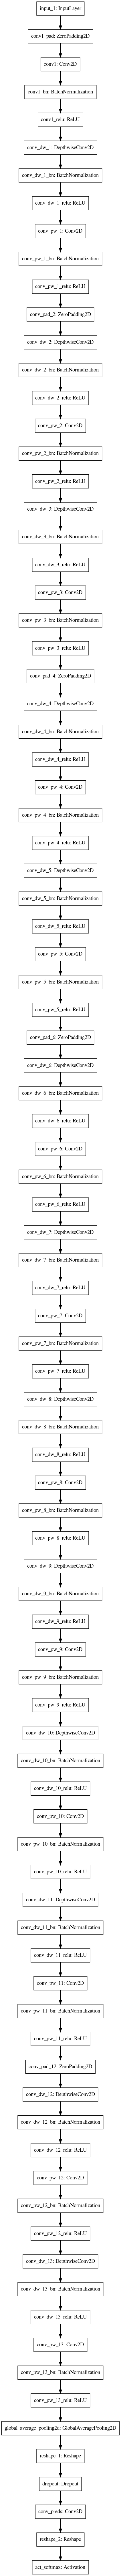

In [7]:
tf.keras.utils.plot_model(model, to_file='model.png')

Download dataset.

Number of training samples 2936
[(0, 'dandelion'), (1, 'daisy'), (2, 'tulips'), (3, 'sunflowers'), (4, 'roses')]


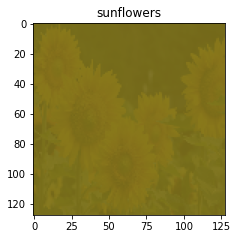

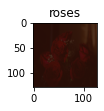

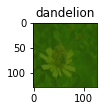

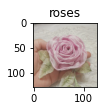

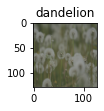

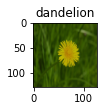

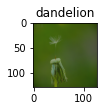

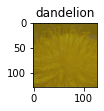

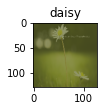

In [8]:
split = list(tfds.Split.TRAIN.subsplit(weighted=split_weights))
(raw_train, raw_val, raw_test), metadata = tfds.load(name='tf_flowers', 
                                                     split=split, 
                                                     data_dir='/media/samuel/DATA2/datasets/', 
                                                     as_supervised=True, 
                                                     with_info=True)

num_train, num_val, num_test = (metadata.splits['train'].num_examples * weight / 10 for weight in split_weights)

print('Number of training samples %d' % num_train)
 
train = raw_train.map(resize_normalize)
val = raw_val.map(resize_normalize)
test = raw_test.map(resize_normalize)

train = train.map(augment)

train = train.shuffle(shuffle_buffer_size).batch(batch_size)
val = val.batch(batch_size)
test = test.batch(batch_size)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

labels = metadata.features['label']
classes = [(i, labels.int2str(i)) for i in range(labels.num_classes)]
get_label_name = labels.int2str
print(classes)

plt.figure(figsize=(12, 12)) 
for btch in train.take(1):
    for i in range(9):
        img, lbl = btch[0][i], btch[1][i]
        plt.subplot(3, 3, i + 1)
        plt.title(get_label_name(lbl.numpy()))
        plt.imshow(img)
        plt.show()

steps_per_epoch = round(num_train) // batch_size
validation_steps = round(num_val) // batch_size

log_dir='logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
os.makedirs(log_dir)

Use Keras' image generator.

Train model.

In [9]:
if training:
    if fine_tuning:
        model.trainable = False
        for layer in model.layers[:fine_tune_at]:
            layer.trainable = True

    history = model.fit(x=train.repeat(), 
                        validation_data=test.repeat(), 
                        steps_per_epoch=steps_per_epoch, 
                        validation_steps=validation_steps, 
                        epochs=epochs, 
                        verbose=1, 
                        callbacks=[checkpointer, reduce_lr, stopper], 
                        shuffle=True).history

Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


91/91 [==============================] - ETA: 0s - loss: 1.6071 - accuracy: 0.2119 - mean_squared_error: 4.8651 - mean_absolute_error: 1.7755 - mean_squared_logarithmic_error: 0.8782 - sparse_categorical_crossentropy: 1.7001
Epoch 00001: val_mean_squared_error improved from -inf to 4.86293, saving model to model.h5
91/91 [==============================] - 7s 80ms/step - loss: 1.6071 - accuracy: 0.2119 - mean_squared_error: 4.8651 - mean_absolute_error: 1.7755 - mean_squared_logarithmic_error: 0.8782 - sparse_categorical_crossentropy: 1.7001 - val_loss: 1.6085 - val_accuracy: 0.2159 - val_mean_squared_error: 4.8629 - val_mean_absolute_error: 1.7926 - val_mean_squared_logarithmic_error: 0.8778 - val_sparse_categorical_crossentropy: 1.6357 - lr: 0.0010
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 1.5882 - accuracy: 0.2810 - mean_squared_error: 4.8481 - mean_absolute_error: 1.7690 - mean_squared_logarithmic_error: 0.8868 - sparse_categorical_crossentropy: 1.7225
Epo

Retrieve and show image before inference.

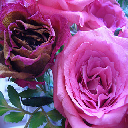

In [10]:
data_dir = pathlib.Path(tf.keras.utils.get_file(origin=origin, fname='flower_photos', untar=True))
flower_path = list(data_dir.glob('*roses*/*'))[0]
img = tf.keras.preprocessing.image.load_img(flower_path, target_size=input_shape)
img

Inference and display of decoded results.

In [11]:
preprocessed_image = prepare_image(img)
predictions = model.predict(preprocessed_image)
decode_predictions(predictions, top_k=5, classes=classes)

[[(0, 'dandelion', 0.901759),
  (2, 'tulips', 0.056436572),
  (3, 'sunflowers', 0.026725873),
  (1, 'daisy', 0.009368791),
  (4, 'roses', 0.0057097757)]]

Optimize for size (quantize weights) then convert to bytecode.

In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
open(model_tflite, 'wb').write(converter.convert())

ConverterError: See console for info.
2020-10-18 20:07:32.435528: W tensorflow/compiler/mlir/lite/python/graphdef_to_tfl_flatbuffer.cc:144] Ignored output_format.
2020-10-18 20:07:32.435551: W tensorflow/compiler/mlir/lite/python/graphdef_to_tfl_flatbuffer.cc:147] Ignored drop_control_dependency.
2020-10-18 20:07:32.454269: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-10-18 20:07:32.476117: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2699905000 Hz
2020-10-18 20:07:32.476541: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55dd014e7510 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-18 20:07:32.476585: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-10-18 20:07:32.477413: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-18 20:07:32.480336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-18 20:07:32.480593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro M3000M computeCapability: 5.2
coreClock: 0.924GHz coreCount: 8 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 149.31GiB/s
2020-10-18 20:07:32.480734: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-10-18 20:07:32.482070: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-10-18 20:07:32.483475: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-10-18 20:07:32.483724: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-10-18 20:07:32.485345: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-10-18 20:07:32.486173: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-10-18 20:07:32.489488: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-10-18 20:07:32.489589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-18 20:07:32.489890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-18 20:07:32.490113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1703] Adding visible gpu devices: 0
2020-10-18 20:07:32.490144: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-10-18 20:07:32.570362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-10-18 20:07:32.570396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1108]      0 
2020-10-18 20:07:32.570425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1121] 0:   N 
2020-10-18 20:07:32.570555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-18 20:07:32.570831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-18 20:07:32.571081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-18 20:07:32.571321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1247] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 4 MB memory) -> physical GPU (device: 0, name: Quadro M3000M, pci bus id: 0000:01:00.0, compute capability: 5.2)
2020-10-18 20:07:32.573064: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55dd02002330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2020-10-18 20:07:32.573078: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro M3000M, Compute Capability 5.2
2020-10-18 20:07:32.576634: I tensorflow/stream_executor/cuda/cuda_driver.cc:763] failed to allocate 4.94M (5177344 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2020-10-18 20:07:32.579205: I tensorflow/stream_executor/cuda/cuda_driver.cc:763] failed to allocate 4.44M (4659712 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2020-10-18 20:07:32.581806: I tensorflow/stream_executor/cuda/cuda_driver.cc:763] failed to allocate 4.00M (4193792 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2020-10-18 20:07:32.584382: I tensorflow/stream_executor/cuda/cuda_driver.cc:763] failed to allocate 3.60M (3774464 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2020-10-18 20:07:32.586982: I tensorflow/stream_executor/cuda/cuda_driver.cc:763] failed to allocate 3.24M (3397120 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2020-10-18 20:07:32.589648: I tensorflow/stream_executor/cuda/cuda_driver.cc:763] failed to allocate 2.92M (3057408 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2020-10-18 20:07:33.119280: F ./tensorflow/core/kernels/conv_2d_gpu.h:659] Non-OK-status: GpuLaunchKernel( SwapDimension1And2InTensor3UsingTiles<T, NumThreads, TileLongSide, TileShortSide>, total_tiles_count, NumThreads, 0, d.stream(), input, input_dims, output) status: Internal: out of memory
Fatal Python error: Aborted

Current thread 0x00007f83ad211740 (most recent call first):
  File "/opt/conda/envs/school/lib/python3.8/site-packages/tensorflow/lite/toco/python/toco_from_protos.py", line 50 in execute
  File "/opt/conda/envs/school/lib/python3.8/site-packages/absl/app.py", line 251 in _run_main
  File "/opt/conda/envs/school/lib/python3.8/site-packages/absl/app.py", line 300 in run
  File "/opt/conda/envs/school/lib/python3.8/site-packages/tensorflow/python/platform/app.py", line 40 in run
  File "/opt/conda/envs/school/lib/python3.8/site-packages/tensorflow/lite/toco/python/toco_from_protos.py", line 93 in main
  File "/opt/conda/envs/school/bin/toco_from_protos", line 11 in <module>
Aborted (core dumped)




Convert the bytecode to characters representing C arrays (the weights).

In [ ]:
!xxd -i $model_tflite > $model_cc
!cat $model_cc